# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import tqdm, sys, os, time, logging, warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as sps

import scanpy as sc
import anndata as ad
import muon as mu

import plotly.express as px
import plotly.graph_objects as go
# sc.set_figure_params(dpi=100, fontsize=10, figsize="8,8", color_map='viridis', transparent=True)
from sklearn.metrics import adjusted_rand_score as ari

# Load

In [2]:
mdata = mu.read_h5mu("data/processed/scRNAseq_snRNAseq_filteredQC.h5mu")
mdata

MuData object with n_obs × n_vars = 258555 × 31053
  obs:	'class_label', 'cluster_color', 'cluster_id', 'cluster_label', 'gene.counts', 'size', 'subclass_label', 'umi.counts'
  2 modalities
    scrna:	74132 x 31053
      obs:	'Amp_Date', 'Amp_Name', 'Amp_PCR_cyles', 'Cell_Capture', 'Donor', 'Gender', 'Lib_Cells', 'Lib_Date', 'Lib_Name', 'Lib_PCR_cycles', 'Lib_PassFail', 'Lib_type', 'Live_Cells', 'Live_percent', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Region', 'Replicate_Lib', 'Saturation', 'Seq_batch', 'Total_Cells', 'aggr_num', 'class_label', 'cluster_color', 'cluster_id', 'cluster_label', 'doublet.score', 'exp_component_name', 'gene.counts', 'library_id', 'mapped_reads', 'method', 'nonconf_mapped_reads', 'size', 'subclass_label', 'total.reads', 'tube_barcode', 'umi.counts', 'unmapped_reads'
      var:	'gene_id'
    snrna:	184423 x 31053
      obs:	'Allen.class_label', 'Allen.cluster_color', 'Allen.cluster_id', 'Allen.cluster_label', 'Allen.subclass_label', 'Broad.QC.Mito', 'Broad.QC.doublet', 'Broad.passQC', 'Comb.QC', 'MALE', 'QC', 'cl', 'class_label', 'cluster', 'cluster_color', 'cluster_id', 'cluster_label', 'comb.QC', 'dataset', 'gene.counts', 'nGene', 'nUMI', 'size', 'subclass_label', 'umi.counts'
      var:	'gene_id'

In [3]:
scrna = mdata['scrna']
snrna = mdata['snrna']

In [4]:
scrna.obsm['counts'] = scrna.X.copy()
snrna.obsm['counts'] = snrna.X.copy()

In [24]:
mdata

MuData object with n_obs × n_vars = 258555 × 31053
  obs:	'class_label', 'cluster_color', 'cluster_id', 'cluster_label', 'gene.counts', 'size', 'subclass_label', 'umi.counts', 'dataset'
  var:	'highly_variable'
  uns:	'neighbors', 'umap'
  obsm:	'X_pca', 'X_umap'
  obsp:	'distances', 'connectivities'
  2 modalities
    scrna:	74132 x 31053
      obs:	'Amp_Date', 'Amp_Name', 'Amp_PCR_cyles', 'Cell_Capture', 'Donor', 'Gender', 'Lib_Cells', 'Lib_Date', 'Lib_Name', 'Lib_PCR_cycles', 'Lib_PassFail', 'Lib_type', 'Live_Cells', 'Live_percent', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Region', 'Replicate_Lib', 'Saturation', 'Seq_batch', 'Total_Cells', 'aggr_num', 'class_label', 'cluster_color', 'cluster_id', 'cluster_label', 'doublet.score', 'exp_component_name', 'gene.counts', 'library_id', 'mapped_reads', 'method', 'nonconf_mapped_reads', 'size', 'subclass_label', 'total.reads', 'tube_barcode', 'umi.counts', 'unmapped_reads', 'dataset'
      var:	'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap'
      obsm:	'counts', 'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    snrna:	184423 x 31053
      obs:	'Allen.class_label', 'Allen.cluster_color', 'Allen.cluster_id', 'Allen.cluster_label', 'Allen.subclass_label', 'Broad.QC.Mito', 'Broad.QC.doublet', 'Broad.passQC', 'Comb.QC', 'MALE', 'QC', 'cl', 'class_label', 'cluster', 'cluster_color', 'cluster_id', 'cluster_label', 'comb.QC', 'dataset', 'gene.counts', 'nGene', 'nUMI', 'size', 'subclass_label', 'umi.counts'
      var:	'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap'
      obsm:	'counts', 'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'

# Data preprocessing

## Normalization

In [5]:
sc.pp.normalize_total(scrna)
sc.pp.log1p(scrna)

In [6]:
sc.pp.normalize_total(snrna)
sc.pp.log1p(snrna)

In [7]:
mdata.X = sps.vstack([mdata['scrna'].X, mdata['snrna'].X])

## Filtering highly variable genes
Uses Scanpy's default settings

In [8]:
sc.pp.highly_variable_genes(scrna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.highly_variable_genes(scrna)

In [9]:
sc.pp.highly_variable_genes(snrna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.highly_variable_genes(snrna)

In [28]:
mdata.var['highly_variable'] = snrna.var
['highly_variable'] & scrna.var['highly_variable']
mdata.var['highly_variable'].sum()

2379

## PCA

In [11]:
sc.tl.pca(scrna, svd_solver='arpack')

In [12]:
sc.tl.pca(snrna, svd_solver='arpack')

In [13]:
# Compute PCA from both datasets concatenated, with the highly_variable genes
mdata.obsm['X_pca'] = sc.tl.pca(mdata.X[:, mdata.var['highly_variable']],  
                                svd_solver='arpack')

## Neighbors

In [14]:
sc.pp.neighbors(scrna, use_rep='X_pca')

In [15]:
sc.pp.neighbors(snrna, use_rep='X_pca')

In [16]:
sc.pp.neighbors(mdata, use_rep='X_pca')

## UMAP

In [17]:
sc.tl.umap(scrna, spread=1., min_dist=.5, random_state=11)

In [18]:
sc.tl.umap(snrna, spread=1., min_dist=.5, random_state=11)

In [19]:
sc.tl.umap(mdata, spread=1., min_dist=.5, random_state=11)

### scRNAseq_A

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


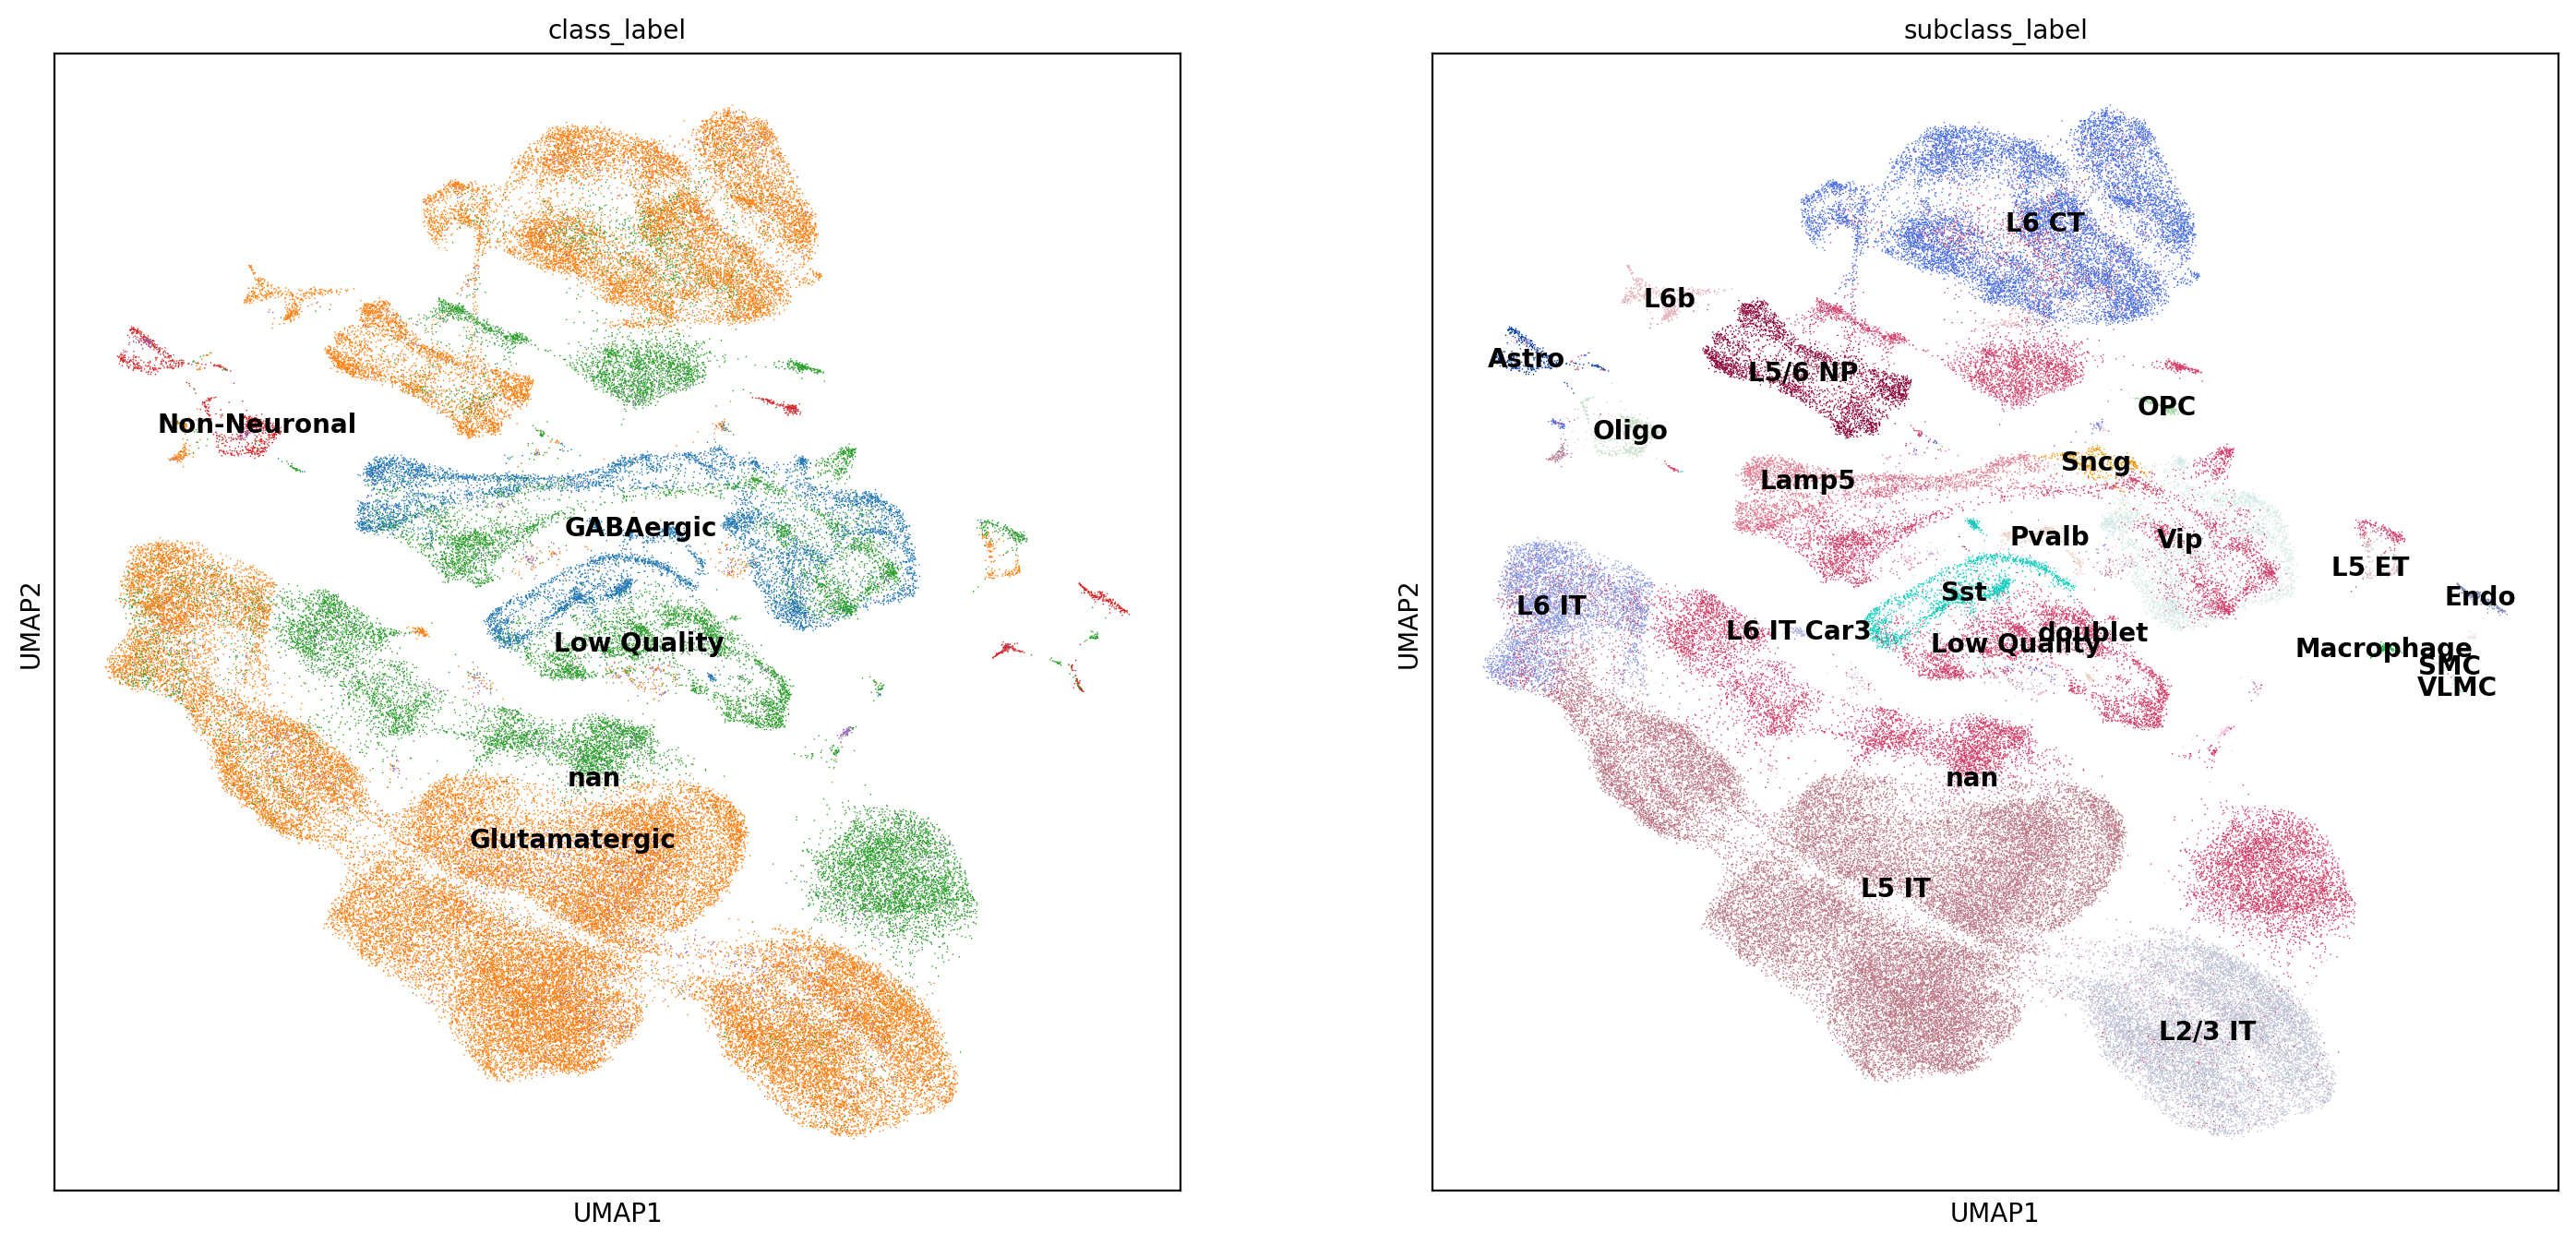

In [59]:
sc.pl.umap(scrna, color=["class_label", "subclass_label"], legend_loc="on data")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


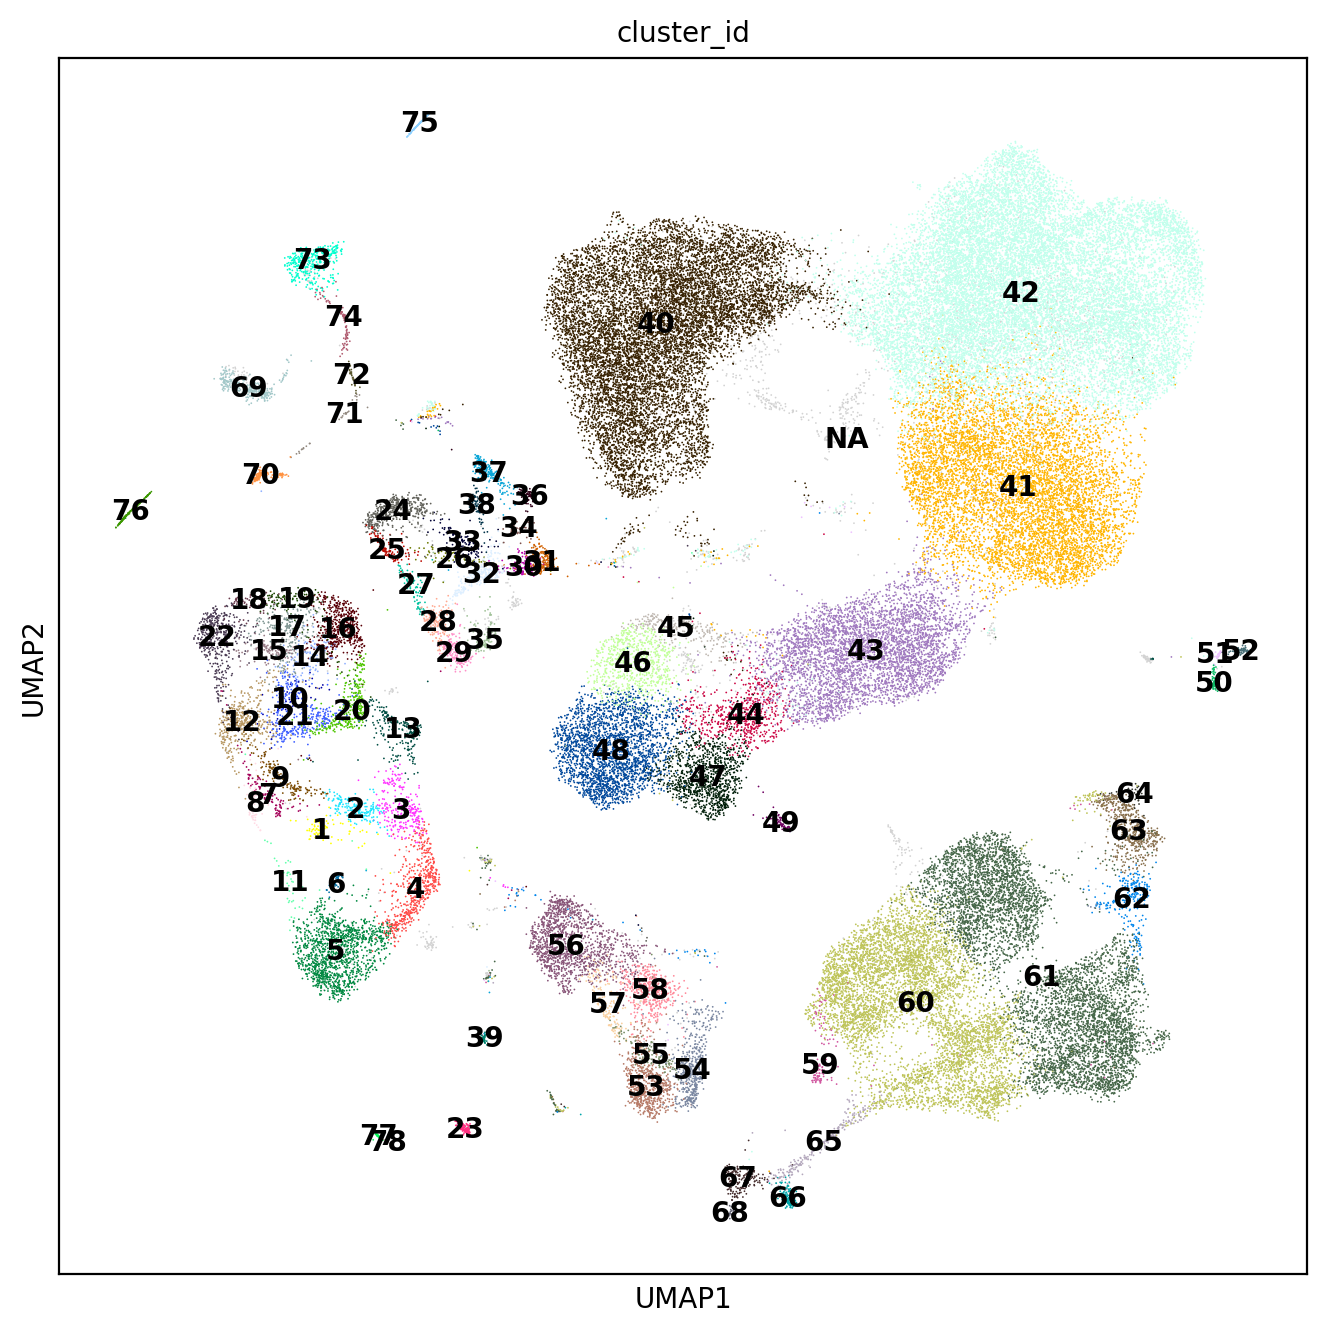

In [40]:
sc.pl.umap(scrna, color="cluster_id", 
           # color_map=scrna.obs.set_index('cluster_id')['cluster_color'].dropna().to_dict(), 
           color_map='viridis',
           legend_loc="on data")

### snRNAseq B

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


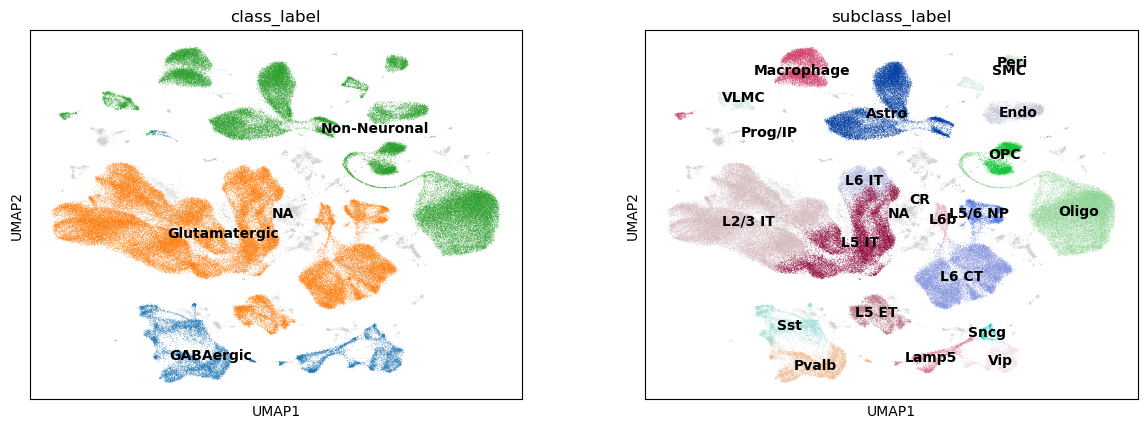

In [24]:
sc.pl.umap(snrna, color=["class_label", "subclass_label"], legend_loc="on data")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


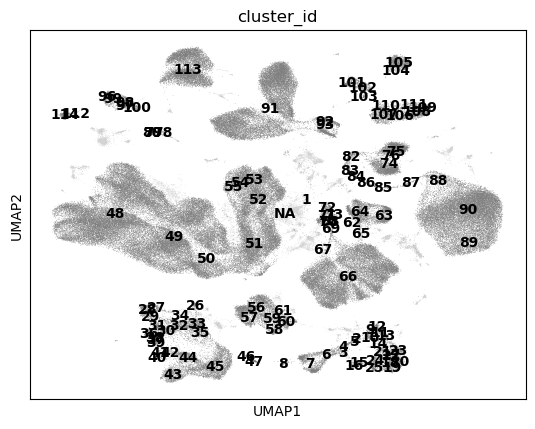

In [25]:
sc.pl.umap(snrna, color="cluster_id", 
           # color_map=scrna.obs.set_index('cluster_id')['cluster_color'].dropna().to_dict(), 
           legend_loc="on data")

## scRNA-seq + snRNA-seq

In [20]:
mdata['scrna'].obs['dataset'] = 'scRNA_10x_v3 A'
mdata['snrna'].obs['dataset'] = 'snRNA_10x_v3 B'
mdata.update()

In [21]:
# Combine cell obs data from both omics
df = pd.DataFrame(mdata.obsm['X_umap'], 
                  columns=['UMAP1','UMAP2'], 
                  index=mdata.obs_names).join(mdata.obs)
df.dtypes

UMAP1                          float32
UMAP2                          float32
scrna:Amp_Date                category
scrna:Amp_Name                category
scrna:Amp_PCR_cyles            float64
scrna:Cell_Capture             float64
scrna:Donor                   category
scrna:Gender                  category
scrna:Lib_Cells                float64
scrna:Lib_Date                category
scrna:Lib_Name                category
scrna:Lib_PCR_cycles           float64
scrna:Lib_PassFail            category
scrna:Lib_type                category
scrna:Live_Cells               float64
scrna:Live_percent            category
scrna:Mean_Reads_perCell       float64
scrna:Median_Genes_perCell     float64
scrna:Median_UMI_perCell       float64
scrna:Region                  category
scrna:Replicate_Lib           category
scrna:Saturation              category
scrna:Seq_batch               category
scrna:Total_Cells              float64
scrna:aggr_num                 float64
scrna:doublet.score      

In [ ]:
px.scatter(df,
           x='UMAP1', y='UMAP2',
           # text='cluster_id',
           color='dataset',
           # color='cluster_id',
           color_discrete_map=df.set_index('cluster_id')['cluster_color'].to_dict(),
           opacity=0.2,
           height=600,
           title="UMAP of scRNA-seq A and snRNA-seq B datasets does not show alignment",
          )

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



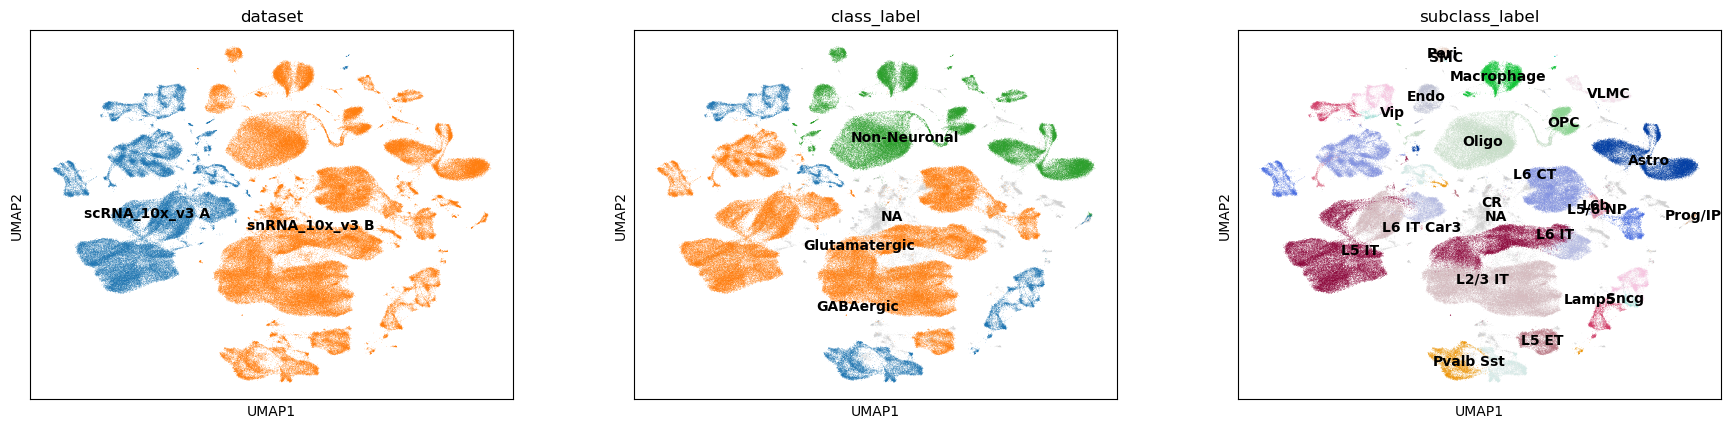

In [29]:
sc.pl.umap(mdata, color=['dataset', "class_label", "subclass_label", ], legend_loc="on data")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



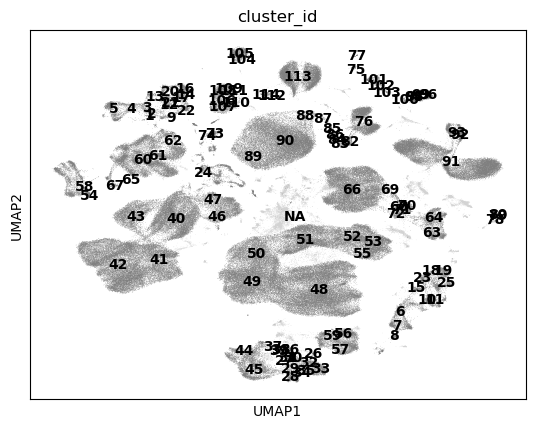

In [30]:
sc.pl.umap(mdata, color="cluster_id", 
           # color_map=scrna.obs.set_index('cluster_id')['cluster_color'].dropna().to_dict(), 
           color_map='viridis',
           legend_loc="on data")

# Save

In [25]:
mdata.write_h5mu("data/processed/scRNAseq_snRNAseq_filteredQC_processedPCA.h5mu")

/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

## Load

In [2]:
mdata = mu.read_h5mu("data/processed/scRNAseq_snRNAseq_filteredQC_processedPCA.h5mu")